In [5]:
import os
import numpy as np
import pandas as pd
import rasterio

# Define the downsampling factor (e.g., downsample by 10)
downsample_factor = 10

# Function to process elevation data for a single file
def process_elevation_file(tif_path, part):
    try:
        with rasterio.open(tif_path) as src:
            data = src.read(1)[::downsample_factor, ::downsample_factor]  # Downsample the data
            transform = src.transform  # Get affine transform for geolocation
    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading file {tif_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

    rows, cols = data.shape
    row_indices, col_indices = np.indices((rows, cols))
    downsampled_transform = transform * rasterio.Affine.scale(downsample_factor)

    lon, lat = rasterio.transform.xy(downsampled_transform, row_indices, col_indices)
    df = pd.DataFrame({
        'longitude': np.array(lon).flatten(),
        'latitude': np.array(lat).flatten(),
        'elevation': data.flatten()
    })

    # Define rounding function to align with Earthdata grid
    def round_to_grid(value, start, step):
        return np.round((value - start) / step) * step + start

    # Apply custom rounding to latitude and longitude to align with Earthdata grid
    df['lon'] = df['longitude'].apply(lambda x: round_to_grid(x, -179.875, 0.25))
    df['lat'] = df['latitude'].apply(lambda x: round_to_grid(x, -65.125, 0.25))

    # Group by new rounded lat and lon, then calculate the mean elevation (averaging duplicates)
    df_rescaled = df.groupby(['lat', 'lon'], as_index=False)['elevation'].mean()

    # Filter out rows where elevation is NaN
    df_rescaled = df_rescaled.dropna(subset=['elevation'])

    return df_rescaled

# Directory where your .tif files are stored
elevation_directory = '..//..//data//elevation//'

# List all .tif files in the directory
tif_files = [f for f in os.listdir(elevation_directory) if f.endswith('.tif')]

# Sort the files to ensure correct pairing
tif_files.sort()

# Loop through all pairs of files (assuming left and right files are adjacent)
for i in range(0, len(tif_files), 2):
    left_file = os.path.join(elevation_directory, tif_files[i])
    right_file = os.path.join(elevation_directory, tif_files[i + 1])

    # Process each part of the file
    df_left = process_elevation_file(left_file, 'left')
    df_right = process_elevation_file(right_file, 'right')

    # Combine left and right DataFrames
    df_combined = pd.concat([df_left, df_right], ignore_index=True)

    # Group by lat, lon, and average the elevation values (this ensures duplicates are handled)
    df_combined = df_combined.groupby(['lat', 'lon'], as_index=False)['elevation'].mean()

    # Filter out rows where elevation is NaN
    df_combined = df_combined.dropna(subset=['elevation'])

    # Save the combined DataFrame for the pair of files
    combined_csv = f'..//..//data/elevation/Global_Elevation_combined_{i // 2}.csv'
    df_combined.to_csv(combined_csv, index=False)
    print(f"Combined data saved to {combined_csv}.")


Combined data saved to ..//..//data/elevation/Global_Elevation_combined_0.csv.
Combined data saved to ..//..//data/elevation/Global_Elevation_combined_1.csv.


In [13]:
df=pd.read_csv('..//..//data/NDVI/ndvi_2020.csv')

# Filter out rows where elevation is 0
df = df[df['ndvi'] != 0]

# Group by latitude and longitude, and aggregate the elevation values
duplicates = df.groupby(['lat', 'lon']).agg(
    count=('lat', 'size'),
    ndvi=('ndvi', 'first')  # Assuming we want the first elevation for each combination
).reset_index()

# Filter for duplicates (count > 1)
duplicates = duplicates[duplicates['count'] > 1]

# Display the duplicate lat/lon combinations with elevation
print(duplicates)
df

Empty DataFrame
Columns: [lat, lon, count, ndvi]
Index: []


,lat,lon,ndvi
0,-59.625,-27.375,-0.068700
1,-59.625,-27.125,-0.053216
2,-56.125,-67.125,0.205900
3,-55.875,-67.875,0.335278
4,-55.875,-67.625,0.459476
...,...,...,...
259581,83.625,-31.125,0.066282
259582,83.625,-30.875,0.028746
259583,83.625,-30.625,0.026964
259584,83.625,-30.375,-0.016531


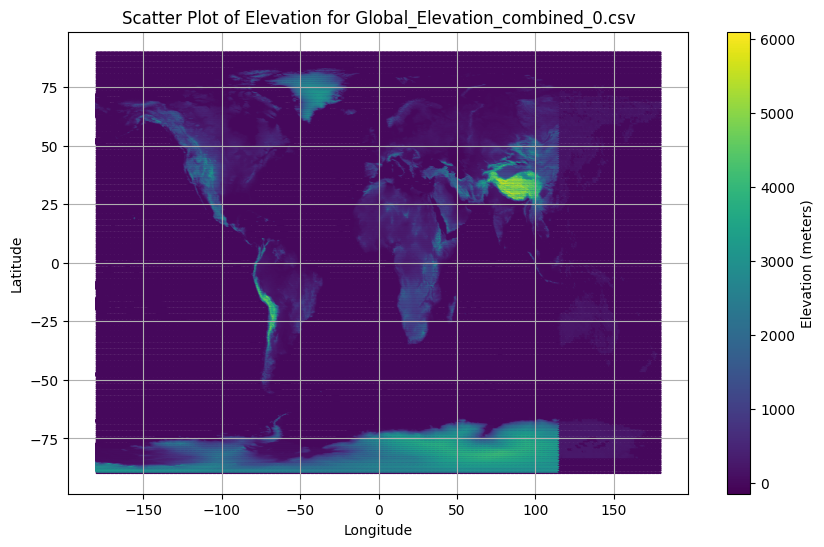

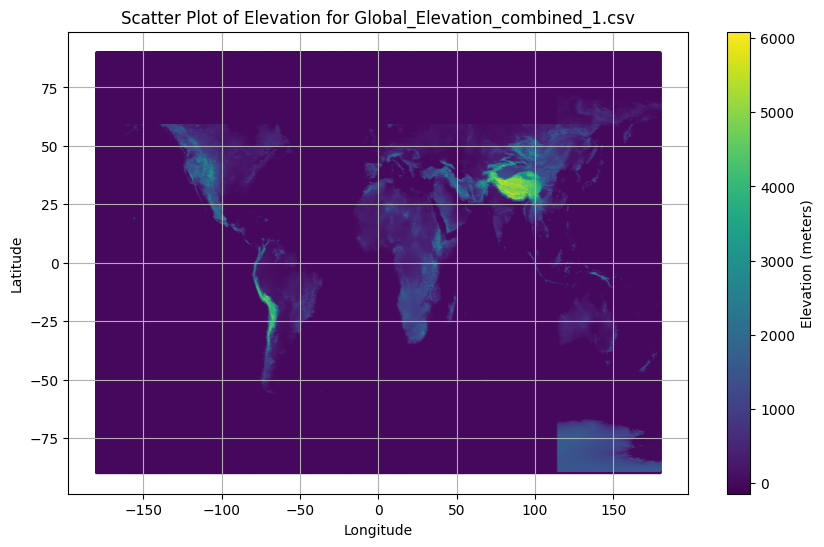

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
df_0 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_0.csv')
df_1 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_1.csv')

# Scatter plot for the first file (Global_Elevation_combined_0.csv)
plt.figure(figsize=(10, 6))
plt.scatter(df_0['lon'], df_0['lat'], c=df_0['elevation'], cmap='viridis', s=1)
plt.colorbar(label='Elevation (meters)')  # Show color bar for elevation
plt.title('Scatter Plot of Elevation for Global_Elevation_combined_0.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# Scatter plot for the second file (Global_Elevation_combined_1.csv)
plt.figure(figsize=(10, 6))
plt.scatter(df_1['lon'], df_1['lat'], c=df_1['elevation'], cmap='viridis', s=1)
plt.colorbar(label='Elevation (meters)')  # Show color bar for elevation
plt.title('Scatter Plot of Elevation for Global_Elevation_combined_1.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd

# Load the CSV files
df_0 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_0.csv')
df_1 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_1.csv')

# Concatenate the two DataFrames
df = pd.concat([df_0, df_1], ignore_index=True)

# Filter out rows where elevation is 0
df = df[df['elevation'] != 0]

# Group by latitude and longitude, and aggregate the elevation values
duplicates = df.groupby(['lat', 'lon']).agg(
    count=('lat', 'size'),
    elevation=('elevation', 'first')  # Assuming we want the first elevation for each combination
).reset_index()

# Filter for duplicates (count > 1)
duplicates = duplicates[duplicates['count'] > 1]

# Display the duplicate lat/lon combinations with elevation
print(duplicates)


           lat      lon  count    elevation
1177   -88.875  114.375      2  3001.803711
2617   -88.625  114.375      2  3032.034180
4057   -88.375  114.375      2  3045.675781
5497   -88.125  114.375      2  3057.232910
6937   -87.875  114.375      2  3066.747314
...        ...      ...    ...          ...
350638  75.375  137.875      2   126.000000
350641  75.375  138.625      2   126.000000
350648  75.375  140.375      2   126.000000
350657  75.375  142.875      2   126.000000
350660  75.375  143.625      2   126.000000

[169770 rows x 4 columns]


In [ ]:
import pandas as pd

# Load the CSV files
df_0 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_0.csv')
df_1 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_1.csv')

# Concatenate the two DataFrames
df = pd.concat([df_0, df_1], ignore_index=True)

# Filter out rows where elevation is 0
df = df[df['elevation'] != 0]

# Group by latitude and longitude, and calculate the average elevation for each group
averaged_df = df.groupby(['lat', 'lon'], as_index=False).agg(
    elevation=('elevation', 'mean')
)

# Display the result with average elevations for duplicate lat/lon combinations
print(averaged_df)



           lat      lon    elevation
0      -88.875 -179.875  3031.245850
1      -88.875 -179.625  3031.899414
2      -88.875 -179.375  3032.445312
3      -88.875 -179.125  3033.379150
4      -88.875 -178.875  3032.671143
...        ...      ...          ...
361591  83.625  -31.375    43.870861
361592  83.625  -31.125    44.039127
361593  83.625  -30.875    27.274441
361594  83.625  -30.625    16.380157
361595  83.625  -30.375     1.726319

[361596 rows x 3 columns]


,lat,lon,count,elevation
1177,-88.875,114.375,2,3001.803711
2617,-88.625,114.375,2,3032.034180
4057,-88.375,114.375,2,3045.675781
5497,-88.125,114.375,2,3057.232910
6937,-87.875,114.375,2,3066.747314
...,...,...,...,...
350638,75.375,137.875,2,126.000000
350641,75.375,138.625,2,126.000000
350648,75.375,140.375,2,126.000000
350657,75.375,142.875,2,126.000000


In [ ]:
import pandas as pd

# Load the CSV files
df_0 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_0.csv')
df_1 = pd.read_csv('..//..//data/elevation/Global_Elevation_combined_1.csv')

# Concatenate the two DataFrames
df = pd.concat([df_0, df_1], ignore_index=True)

# Filter out rows where elevation is 0
df = df[df['elevation'] != 0]

# Group by latitude and longitude, and calculate the average elevation for each group
averaged_df = df.groupby(['lat', 'lon'], as_index=False).agg(
    elevation=('elevation', 'mean')
)

averaged_df

No duplicates found in lat/lon combinations.


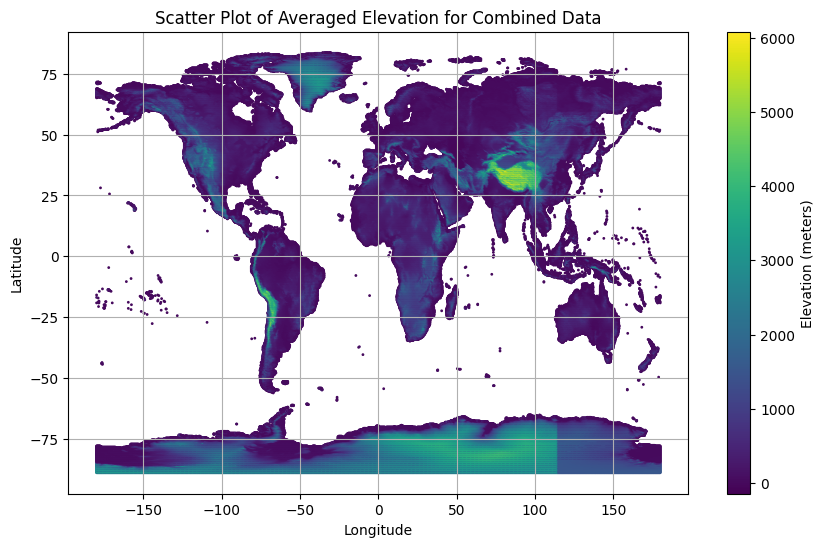

In [9]:
import matplotlib.pyplot as plt

# Scatter plot for the averaged data (after calculating the mean elevation)
plt.figure(figsize=(10, 6))
plt.scatter(averaged_df['lon'], averaged_df['lat'], c=averaged_df['elevation'], cmap='viridis', s=1)
plt.colorbar(label='Elevation (meters)')  # Show color bar for elevation
plt.title('Scatter Plot of Averaged Elevation for Combined Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [ ]:
average_df = pd.to('..//..//data/elevation/Global_Elevation_combined_1.csv')
"elevation" "lat" "lon" "elevation"




In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import dotenv_values

# Load database configuration from .env file
config = dotenv_values()
pg_user = config['POSTGRES_USER']
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_pass = config['POSTGRES_PASS']
pg_schema = config['POSTGRES_SCHEMA']

# Create the connection URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)

# SQL query to select the first row of each lon-lat combination
query = f"""
    SELECT *           
    FROM "{pg_schema}"."20241111_data_to_predict"
"""

# Execute the query and load the result into a DataFrame
with engine.connect() as connection:
    df = pd.read_sql_query(text(query), connection)

# Save the DataFrame to CSV
df.to_csv("New_Data_to_predict_2020.csv", index=False)

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values

# Load database configuration from .env file
config = dotenv_values()
pg_user = config['POSTGRES_USER']
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_pass = config['POSTGRES_PASS']
pg_schema = config['POSTGRES_SCHEMA']

# Create the connection URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)

# Step 1: Save the averaged_df to a CSV file in the 'elevation' folder
#csv_file_path = '..//..//data/elevation/elevation.csv'
#averaged_df.to_csv(csv_file_path, index=False)
#print(f"Averaged elevation data saved to {csv_file_path}")

# Step 2: Upload the averaged_df DataFrame to the PostgreSQL database as 'elevation' table
# The table will be created if it doesn't exist; otherwise, it will replace existing data.
with engine.connect() as connection:
    df.to_sql('ndvi_2020', connection, schema=pg_schema, if_exists='replace', index=False)
    print("Data successfully uploaded to the 'elevation' table in the database.")

Data successfully uploaded to the 'elevation' table in the database.


: 